### Import Libraries

In [306]:
from sklearn import cluster, metrics, preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from kmodes.kprototypes import KPrototypes

cwd = os.getcwd()

### Open Dataset and Data review

In [296]:
def count(data, column):
    sns.countplot(x=column, data=data)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

In [300]:
data_dir = os.path.join(cwd, 'data/')
data = pd.read_csv(os.path.join(data_dir, 'ObesityDataSet_raw_and_data_sinthetic.csv'))
data['bmi'] = 1.3 * data['Weight'] / (data['Height'] ** 2.5)
data = data.drop(columns=['Height','Weight'], axis=1)
data.head(10)


,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,bmi
0,Female,21.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.907824
1,Female,21.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,25.557738
2,Male,23.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.027819
3,Male,27.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.018445
4,Male,22.0,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,27.616567
5,Male,29.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight,20.626792
6,Female,23.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight,25.946447
7,Male,22.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,20.003666
8,Male,24.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight,19.682185
9,Male,22.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight,22.784062


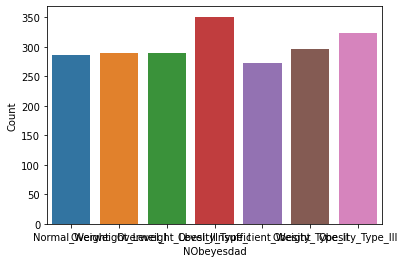

In [304]:
count(data, 'NObeyesdad')

### Data Preprocessing

In [284]:
# rename columns where column name is tooo long
data.rename(columns={'family_history_with_overweight': 'family_history'}, inplace=True)

# print some column not is numeric
print(f"""
Gender: {set(data['Gender'])}
family_history_with_overweight: {set(data['family_history'])}
FAVC: {set(data['FAVC'])}
CAEC: {set(data['CAEC'])}
SMOKE: {set(data['SMOKE'])}
SCC: {set(data['SCC'])}
CALC: {set(data['CALC'])}
MTRANS: {set(data['MTRANS'])}
NObeyesdad: {set(data['NObeyesdad'])}
""")
data.head()


Gender: {'Male', 'Female'}
family_history_with_overweight: {'no', 'yes'}
FAVC: {'yes', 'no'}
CAEC: {'Sometimes', 'no', 'Always', 'Frequently'}
SMOKE: {'yes', 'no'}
SCC: {'yes', 'no'}
CALC: {'Sometimes', 'no', 'Always', 'Frequently'}
MTRANS: {'Walking', 'Automobile', 'Bike', 'Motorbike', 'Public_Transportation'}
NObeyesdad: {'Insufficient_Weight', 'Obesity_Type_II', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_III', 'Normal_Weight', 'Obesity_Type_I'}



,Gender,Age,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,bmi
0,Female,21.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.907824
1,Female,21.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,25.557738
2,Male,23.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.027819
3,Male,27.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.018445
4,Male,22.0,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,27.616567


In [285]:
def onehot_encoder(data, columns):
    dummies = pd.get_dummies(data, columns=columns)
    return dummies

def label_encoder(data, columns):
    le = preprocessing.LabelEncoder()
    for column in columns:
        data[column] = le.fit_transform(data[column])
    return data

In [286]:
# normalize:
# age, 
# bmi, 
# Time using technology devices (TUE), 
# Physical activity frequency (FAF), 
# Consumption of water daily (CH20),
# Number of main meals (NCP),
# Frequency of consumption of vegetables (FCVC),

norm = data.copy()
scaler = preprocessing.MinMaxScaler()
norm[['Age', 'bmi', 'TUE', 'FAF', 'CH2O', 'NCP', 'FCVC']] = scaler.fit_transform(norm[['Age', 'bmi', 'TUE', 'FAF', 'CH2O', 'NCP', 'FCVC']])
# reorder
norm = norm.reindex(columns=[ 'Age', 'bmi', 'TUE', 'FAF', 'CH2O', 'NCP', 'FCVC', 'Gender', 'family_history', 'FAVC', 'CAEC','SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad',])

# drop target column
normWithoutTarget = norm.drop(columns=['NObeyesdad', 'bmi'])

#norm.head()
normWithoutTarget.head()

,Age,TUE,FAF,CH2O,NCP,FCVC,Gender,family_history,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
0,0.148936,0.5,0.000000,0.5,0.666667,0.5,Female,yes,no,Sometimes,no,no,no,Public_Transportation
1,0.148936,0.0,1.000000,1.0,0.666667,1.0,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation
2,0.191489,0.5,0.666667,0.5,0.666667,0.5,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation
3,0.276596,0.0,0.666667,0.5,0.666667,1.0,Male,no,no,Sometimes,no,no,Frequently,Walking
4,0.170213,0.0,0.000000,0.5,0.000000,0.5,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation


### Cluster Method 1: Kprototypes (Bad...)
Try and error then abandon :)

In [287]:
kproto = KPrototypes(n_clusters=7, init='Cao')
clusters = kproto.fit_predict(normWithoutTarget, categorical=list(range(6, 14)))
labels = pd.DataFrame(clusters)
labeledData = pd.concat((normWithoutTarget, labels),axis=1)
labeledData = labeledData.rename({0:'predict cluster'},axis=1)
labeledData.insert(column='actual cluster', loc=len(labeledData.columns), value=data['NObeyesdad'])
labeledData

,Age,TUE,FAF,CH2O,NCP,FCVC,Gender,family_history,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,predict cluster,actual cluster
0,0.148936,0.500000,0.000000,0.500000,0.666667,0.5,Female,yes,no,Sometimes,no,no,no,Public_Transportation,0,Normal_Weight
1,0.148936,0.000000,1.000000,1.000000,0.666667,1.0,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation,4,Normal_Weight
2,0.191489,0.500000,0.666667,0.500000,0.666667,0.5,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation,2,Normal_Weight
3,0.276596,0.000000,0.666667,0.500000,0.666667,1.0,Male,no,no,Sometimes,no,no,Frequently,Walking,2,Overweight_Level_I
4,0.170213,0.000000,0.000000,0.500000,0.000000,0.5,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation,6,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.148443,0.453123,0.558756,0.364069,0.666667,1.0,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,3,Obesity_Type_III
2107,0.169850,0.299635,0.447130,0.502565,0.666667,1.0,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,4,Obesity_Type_III
2108,0.181362,0.323144,0.471403,0.527097,0.666667,1.0,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,4,Obesity_Type_III
2109,0.220467,0.293018,0.379702,0.926169,0.666667,1.0,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,4,Obesity_Type_III


In [288]:
# 效果不好...
labeledData.to_csv('result.csv')

### Cluster Method 2: Kmeans with one hot encoding

In [289]:
kmeans_with_onehot = data.copy()

# one hot encoding
label_encoder(kmeans_with_onehot, ['NObeyesdad'])
kmeans_with_onehot = onehot_encoder(kmeans_with_onehot, ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'])

# reorder colmun
kmeans_with_onehot = kmeans_with_onehot.reindex(columns=[
       'Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Female', 'Gender_Male', 'family_history_no',
       'family_history_yes', 'FAVC_no', 'FAVC_yes', 'CAEC_Always',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_no', 'SMOKE_yes',
       'SCC_no', 'SCC_yes', 'CALC_Always', 'CALC_Frequently', 'CALC_Sometimes',
       'CALC_no', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking', 'bmi', 'NObeyesdad'])
kmeans_with_onehot.head(10)

,Age,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_no,family_history_yes,...,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,bmi,NObeyesdad
0,21.0,2.0,3.0,2.0,0.0,1.0,1,0,0,1,...,0,0,1,0,0,0,1,0,24.907824,1
1,21.0,3.0,3.0,3.0,3.0,0.0,1,0,0,1,...,0,1,0,0,0,0,1,0,25.557738,1
2,23.0,2.0,3.0,2.0,2.0,1.0,0,1,0,1,...,1,0,0,0,0,0,1,0,23.027819,1
3,27.0,3.0,3.0,2.0,2.0,0.0,0,1,1,0,...,1,0,0,0,0,0,0,1,26.018445,5
4,22.0,2.0,1.0,2.0,0.0,0.0,0,1,1,0,...,0,1,0,0,0,0,1,0,27.616567,6
5,29.0,2.0,3.0,2.0,0.0,0.0,0,1,1,0,...,0,1,0,1,0,0,0,0,20.626792,1
6,23.0,3.0,3.0,2.0,1.0,0.0,1,0,0,1,...,0,1,0,0,0,1,0,0,25.946447,1
7,22.0,2.0,3.0,2.0,3.0,0.0,0,1,1,0,...,0,1,0,0,0,0,1,0,20.003666,1
8,24.0,3.0,3.0,2.0,1.0,1.0,0,1,0,1,...,1,0,0,0,0,0,1,0,19.682185,1
9,22.0,2.0,3.0,2.0,1.0,1.0,0,1,0,1,...,0,0,1,0,0,0,1,0,22.784062,1


In [290]:
x = kmeans_with_onehot.iloc[:, :29].values

kmeans = cluster.KMeans(n_clusters=7).fit(x)
labels = kmeans.labels_
print(f"分群結果:\n{(labels + 1)[:5]}")
print(f"---")
print(f"原始結果:\n{data['NObeyesdad'][:5]}")

分群結果:
[2 2 2 5 2]
---
原始結果:
0          Normal_Weight
1          Normal_Weight
2          Normal_Weight
3     Overweight_Level_I
4    Overweight_Level_II
Name: NObeyesdad, dtype: object


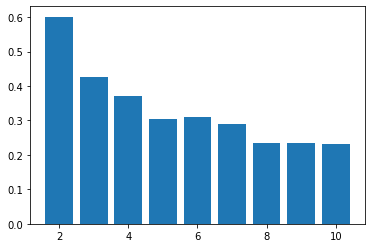

In [291]:
# Kmeans
perf = []
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k).fit(x)
    labels = kmeans.labels_
    avg = metrics.silhouette_score(x, labels)
    perf.append(avg)

plt.bar(range(2, 11), perf)
plt.show()


In [292]:
### Cluster Method 2: Kmeans with label encoding

kmeans_with_label_encoding = data.copy()

# label encoding
label_encoder(kmeans_with_label_encoding, ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad'])


kmeans_with_label_encoding.head(10)

,Gender,Age,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,bmi
0,0,21.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1,24.907824
1,0,21.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1,25.557738
2,1,23.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1,23.027819
3,1,27.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5,26.018445
4,1,22.0,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6,27.616567
5,1,29.0,0,1,2.0,3.0,2,0,2.0,0,0.0,0.0,2,0,1,20.626792
6,0,23.0,1,1,3.0,3.0,2,0,2.0,0,1.0,0.0,2,2,1,25.946447
7,1,22.0,0,0,2.0,3.0,2,0,2.0,0,3.0,0.0,2,3,1,20.003666
8,1,24.0,1,1,3.0,3.0,2,0,2.0,0,1.0,1.0,1,3,1,19.682185
9,1,22.0,1,1,2.0,3.0,2,0,2.0,0,1.0,1.0,3,3,1,22.784062


In [293]:
x = kmeans_with_label_encoding.iloc[:, :14].values

kmeans = cluster.KMeans(n_clusters=7).fit(x)
labels = kmeans.labels_
print(f"分群結果:\n{(labels + 1)[:5]}")
print(f"---")
print(f"原始結果:\n{data['NObeyesdad'][:5]}")

分群結果:
[6 6 6 1 6]
---
原始結果:
0          Normal_Weight
1          Normal_Weight
2          Normal_Weight
3     Overweight_Level_I
4    Overweight_Level_II
Name: NObeyesdad, dtype: object


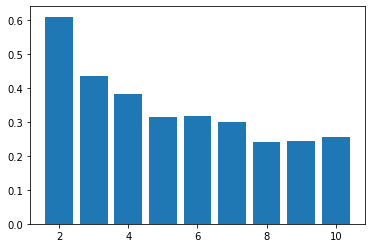

In [294]:
# Kmeans
perf = []
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k).fit(x)
    labels = kmeans.labels_
    avg = metrics.silhouette_score(x, labels)
    perf.append(avg)

plt.bar(range(2, 11), perf)
plt.show()
